# Trained model evaluation

## Results
Voxel size 가 0.05, 0.1, 0.2, 0.5 일때 test set classification 성능
```
Evaluation results - train
Correct / incorrect : 14603 / 7 - 99.9520876112% 

Evaluation results - v050
Correct / incorrect : 14606 / 4 - 99.9726214921% 

Evaluation results - v100
Correct / incorrect : 14604 / 6 - 99.9589322382% 

Evaluation results - v200
Correct / incorrect : 14414 / 196 - 98.6584531143% 

Evaluation results - v500
Correct / incorrect : 9374 / 5236 - 64.1615331964% 
```



In [1]:
import os, sys

sys.path.append( os.path.abspath('../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../model') )
from train import *
import model as MODEL

In [2]:
""" Parameters """
model_path = os.path.abspath('../notebook/train_log_20181020/model/backup/model.ckpt')

data_test_path = []

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v2_20181019_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

# dtp = os.path.join( \
#           os.path.abspath('../../Dataset/dataset/db_aug_v2_v_050_20181019_ndb_aug_v2_20181020'), 'test.h5' \
#                   )
# data_test_path.append(dtp)

# dtp = os.path.join( \
#           os.path.abspath('../../Dataset/dataset/db_aug_v2_v_100_20181019_ndb_aug_v2_20181020'), 'test.h5' \
#                   )
# data_test_path.append(dtp)

# dtp = os.path.join( \
#           os.path.abspath('../../Dataset/dataset/db_aug_v2_v_200_20181019_ndb_aug_v2_20181020'), 'test.h5' \
#                   )
# data_test_path.append(dtp)

# dtp = os.path.join( \
#           os.path.abspath('../../Dataset/dataset/db_aug_v2_v_500_20181019_ndb_aug_v2_20181020'), 'test.h5' \
#                   )
# data_test_path.append(dtp)

data_name_list = ['train', 'v050', 'v100', 'v200', 'v500']


""" Parameters """
GPU_INDEX = 0
NUM_POINT = 256
NUM_CLASSES = 3

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 10

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 10

Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v2_20181019_ndb_aug_v2_20181020/test.h5


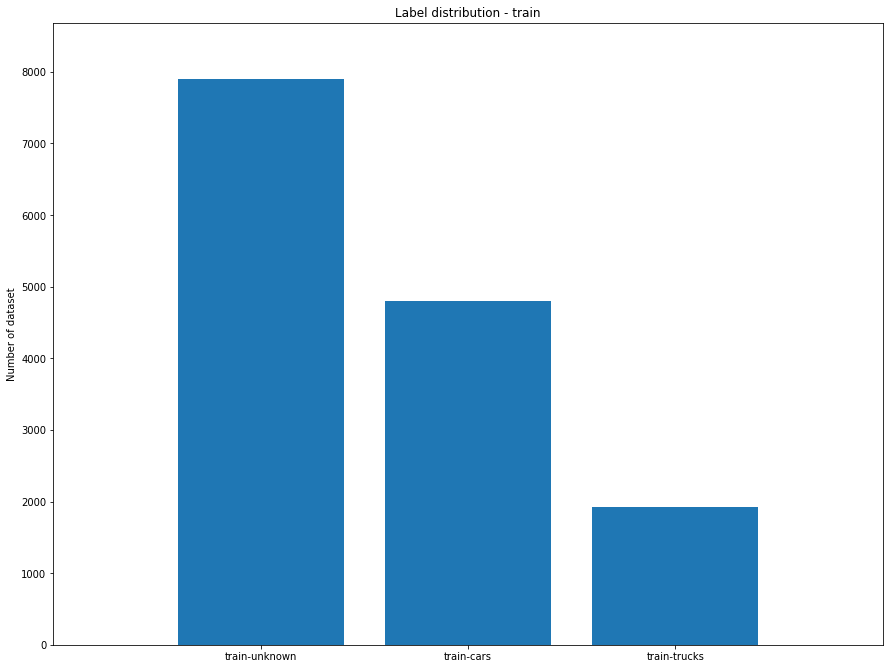

In [3]:
""" Load dataset """
data = []
label = []

for dtp in data_test_path:
    d, l = load_h5(dtp)
    
    data.append(d)
    label.append(l)
    
    print "Load data: {}".format(dtp)
    

""" Data statistics"""
label_list = [0,1,2]

plt.close('all')
fig = plt.figure( figsize=(12,9) )
fig.subplots_adjust(left=0.02,top= 0.98,bottom=0.02,right=0.98,wspace=0.1,hspace=0.5)


for i in range( len(data) ):
    y_val = []
    x_name = []

    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

    x_name.append("{}-unknown".format(data_name_list[i]))
    x_name.append("{}-cars".format(data_name_list[i]))
    x_name.append("{}-trucks".format(data_name_list[i]))

    index = range( len(x_name) )
    
    ax=fig.add_subplot(len(data),1,i+1)

    ax.bar(index, y_val, tick_label=x_name, align='center')
    ax.set_ylabel('Number of dataset')
    ax.set_title('Label distribution - {}'.format(data_name_list[i]))
    ax.set_xlim( -1, len(x_name))
    ax.set_ylim( 0, np.max(y_val) * 1.1 )
plt.show()


In [4]:
is_training = False

# reset graph
tf.reset_default_graph()

with tf.device('/gpu:'+str(GPU_INDEX)):
    pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
    is_training_pl = tf.placeholder(tf.bool, shape=())

    # simple model
    pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
    loss = MODEL.get_loss(pred, labels_pl, end_points)

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True

ops = {'pointclouds_pl': pointclouds_pl,
       'labels_pl': labels_pl,
       'is_training_pl': is_training_pl,
       'pred': pred,
       'loss': loss}

# ops.reset_default_graph() 

sess = tf.Session(config=config)

# Restore variables from disk.
saver.restore(sess, model_path)

print "Model restored"
sys.stdout.flush()

results_list = []
for i in range(len(data)):
    
    print "Dataset {} / {} ".format(i+1, len(data))
    sys.stdout.flush()
    
    ## Evaluation using test set    
    is_training = False
    total_correct = 0
    total_seen = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    total_detect_class = [0 for _ in range(NUM_CLASSES)]
    total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

    current_data = data[i]
    current_label = label[i]

    num_batches = current_data.shape[0] // BATCH_SIZE

    results = []

    for batch_idx in trange(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx],
                     ops['labels_pl']: current_label[start_idx:end_idx],
                     ops['is_training_pl']: is_training}
        loss_val, pred_val = sess.run([ops['loss'], ops['pred']],
                                  feed_dict=feed_dict)

        pred_val = np.argmax(pred_val, 1)
        results.extend(pred_val)
    
    results_list.append(results)


INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from /media/kyungpyo/SmartCarContest/MasterThesisProject/Network/notebook/train_log_20181020/model/backup/model.ckpt
Model restored
Dataset 1 / 1 


100%|██████████| 1461/1461 [02:08<00:00, 11.37it/s]


In [5]:
incorrect_idx_list = []

for i, results in enumerate(results_list):

    print "Evaluation results - {}".format(data_name_list[i])
    
    prediction = np.array(results)
    ground_truth = np.array(label[i][:prediction.shape[0]])
    correct = np.sum( prediction == ground_truth )

    incorrect_idx = []

    for i, gt in enumerate(ground_truth):

        pred = prediction[i]

        if not gt == pred:

            incorrect_idx.append(i)

            #print "gt: {}, pred: {}".format(gt, pred)

    print "Correct / incorrect : {} / {} - {}% \n".format( 
        ground_truth.shape[0] - len(incorrect_idx) , 
        len(incorrect_idx),
        float( ground_truth.shape[0] - len(incorrect_idx) ) / float( ground_truth.shape[0] ) * 100 )
    
    incorrect_idx_list.append(incorrect_idx)
    

Evaluation results - train
Correct / incorrect : 14603 / 7 - 99.9520876112% 



In [14]:
""" Display """
data_sel = 0
num_of_fig = 7

%matplotlib qt
label_list = [0,1,2]

plt.close('all')
fig = plt.figure( figsize=(12,9) )
fig.subplots_adjust(left=0.02,top= 0.98,bottom=0.02,right=0.98,wspace=0.1,hspace=0.5)


incorrect_idx = incorrect_idx_list[data_sel]

if len(incorrect_idx) < num_of_fig: num_of_fig = len(incorrect_idx)
    
# display point cloud
crn = int( np.sqrt(num_of_fig) ) + 1

idx_offset = 0

for i in range(num_of_fig):
    
    idx = idx_offset + incorrect_idx[i]

    prediction = np.array(results_list[data_sel])
    ground_truth = np.array(label[data_sel][:prediction.shape[0]])

    ax = fig.add_subplot(crn, crn, i+1, projection='3d')
    ax = display_point_cloud_box_ax(ax, data[data_sel][idx])
    ax.set_title("idx: {}, gt: {}, pred: {}".format(idx, ground_truth[idx], prediction[idx]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

figManager = plt.get_current_fig_manager()
figManager.window.showMaximized()    
plt.show()
